In [1]:
# This section focuses on importing the zip file from the user's local machine
from google.colab import files
import zipfile

uploaded = files.upload() # Will give the user a prompt to upload the zip file

# Extracting the dataset from the zip file
with zipfile.ZipFile("brain_tumor_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Defining the path for the dataset (this is the structure since there is the brain_tumor_dataset folder within the zip)
dataset_path = "/content/brain_tumor_dataset/brain_tumor_dataset"

print("Dataset uploaded, the path is " + dataset_path) # Ensuring that there are no errors with the upload of the file


Saving brain_tumor_dataset.zip to brain_tumor_dataset.zip
Dataset uploaded, the path is /content/brain_tumor_dataset/brain_tumor_dataset


In [2]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Creating paths for the train, validation, test folders
base_dir = "/content/split_dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Creating the 6 folders needed for training, validation, testing, each one with a yes and no subfolder.
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(folder, "yes"), exist_ok=True)
    os.makedirs(os.path.join(folder, "no"), exist_ok=True)


# Getting the 'yes' and 'no' images from the initial dataset
yes_images = os.listdir(os.path.join(dataset_path, "yes"))
no_images = os.listdir(os.path.join(dataset_path, "no"))


"""
A function which splits the files into training, validation, testing sets and then moves these files to each of the 6 folders previously created.

Using a random_state value means that the data will be split the same way every time.
"""
def split_and_move(files, category):
    train_files, temp_files = train_test_split(files, test_size=0.3, random_state=10) # Splits the files into training (70% of files) and the rest 30% into a temporary file.
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=10) # Splits the temporary file in half, used for validation (15%) and testing (15%).

    # For each file (f) in each folder, it is moved into the directory (creating 6 folders)
    for f in train_files:
        shutil.move(os.path.join(dataset_path, category, f), os.path.join(train_dir, category, f)) # Moves all the training files into the training directory
    for f in val_files:
        shutil.move(os.path.join(dataset_path, category, f), os.path.join(val_dir, category, f)) # Moves all the validation files into the validation directory
    for f in test_files:
        shutil.move(os.path.join(dataset_path, category, f), os.path.join(test_dir, category, f)) # Moves all the testing files into the validation directory

# Splits and moves the images
split_and_move(yes_images, "yes")
split_and_move(no_images, "no")

print("The dataset has been split into 6 folders") # Ensuring that everything runs smoothly



The dataset has been split into 6 folders


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224) # Defining the size of the images
BATCH_SIZE = 20 # Defining how many images can be processed at once

# I am using image augmentation with default/common parameters to increase the size of the dataset. This is only used for model training, not validation and testing
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             rotation_range=30,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode='nearest')

normal_data_generator = ImageDataGenerator(rescale=1./255) # This is going to be used by the validation and testing as these should not be augmented

# Loading the data for training, valdiation, and testing
train_generator = training_data_generator.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary' # Here shuffle is automatically True, meaning that different images are used in each epoch for training
)

val_generator = normal_data_generator.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

# Here I have set shuffle = False in order to have steady testing data which is in the same order every time.
test_generator = normal_data_generator.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle = False
)


Found 156 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Finding sufficient weights for each class to fix the class imbalance.
y_train = train_generator.classes

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train) # Automatically finds the class weights based on the class frequencies
class_weights = dict(enumerate(class_weights))  # Converting to a dictionary

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Using the convolutional base of VGG16

def create_vgg16_model(learning_rate=0.001, dropout_rate=0.4):

    # Freezing the convolutional base so that it cannot be trained at first
    base_model.trainable = False

    # Adding custom fully connected layers on top
    model = Sequential([
        base_model,

        Flatten(),  # Converts the feature maps into vectors
        Dense(128, activation='relu'),
        Dropout(dropout_rate), # Randomly drops out some neurons to prevent overfitting
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Uses sigmoid for binary classification (Tumor or Non-Tumor)
    ])

    # Compiling the model with the Adam optimiser
    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Creating an instance of the model
model = create_vgg16_model()
EPOCHS = 20
BATCH_SIZE = 32

# Training only the fully connected layers first
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    batch_size=BATCH_SIZE
)


# Unfreezing the last few layers of VGG16 for fine-tuning
base_model.trainable = True

# Compiling it again to allow for fine-tuning
# A small learning rate has been used as this is optimal for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Fine-tuning the model
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Fewer epochs as fine-tuning requires less epochs
    class_weight=class_weights,
    batch_size=BATCH_SIZE
)


test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss: ", test_loss)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.5794 - loss: 1.1911 - val_accuracy: 0.3333 - val_loss: 1.0058
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4006 - loss: 1.5223 - val_accuracy: 0.3333 - val_loss: 0.7275
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.5020 - loss: 1.0627 - val_accuracy: 0.7273 - val_loss: 0.6583
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4433 - loss: 0.8421 - val_accuracy: 0.7879 - val_loss: 0.6437
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4883 - loss: 0.7631 - val_accuracy: 0.8485 - val_loss: 0.6244
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6270 - loss: 0.7156 - val_accuracy: 0.7879 - val_loss: 0.6352
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.5792 - loss: 0.7012 - val_accuracy: 0.8485 - val_loss: 0.6044
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6382 - loss: 0.6189 - val_accuracy: 0.7576 - val_loss: 0.6188
Epoch 9/

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8324 - loss: 0.5479
Test Accuracy: 0.8235294222831726
Test Loss:  0.5874870419502258


In [8]:
# Producing all of the relevant metrics

from sklearn.metrics import classification_report

y_pred = model.predict(test_generator) # Predicting the test data
classes_y_pred = (y_pred > 0.5).astype(int)

y_true = test_generator.classes

print(classification_report(y_true=y_true, y_pred=classes_y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.90      0.83      0.86        23

    accuracy                           0.82        34
   macro avg       0.80      0.82      0.81        34
weighted avg       0.84      0.82      0.83        34



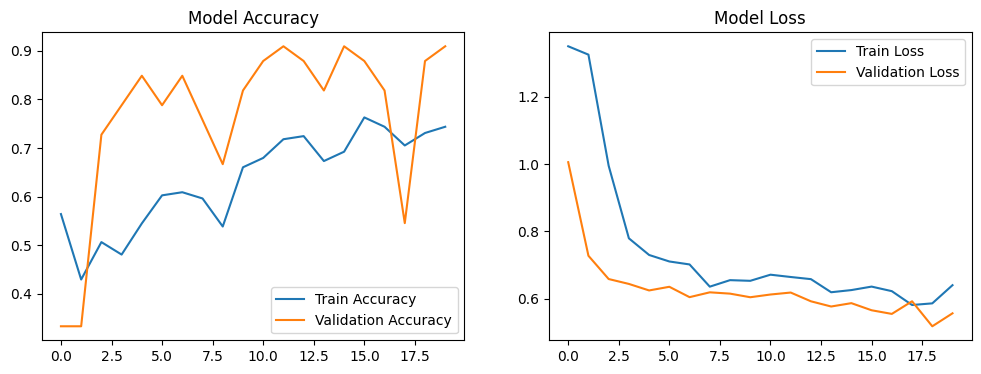

In [11]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 4)) # Size of the plot (including two plots)

# Plotting Training vs. Validation Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy') # Getting the training accuracy values
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Getting the validation accuracy values
plt.legend()
plt.title('Model Accuracy')

# Plotting Training vs. Validation Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss') # Getting the loss values
plt.plot(history.history['val_loss'], label='Validation Loss') # Getting the validation loss values
plt.legend()
plt.title('Model Loss')

plt.show()